# The Moving Averages Crossover Strategy - 

* A possible trend reversal opens up an opportunity for initiating a trade.
* In this notebook, we shall leverage moving averages to identify a change in trend for any given ticker. 
* The Moving Averages crossover strategy involves the use of a longer-term (n) MA and a shorter-term MA (m) for the same chart.
* The shorter-term MAs will help us capture the short-term changes in stock prices whereas the longer-term MAs will help us keep track of stock prices over a longer period. 
* As a result, the strategy gives a buy signal when the shorter-term MA crosses above the longer-term MA, indicating an upward trend for the stock prices. This crossover is also known as a Golden cross.  
* Similarly, the strategy gives a signal to sell when the shorter-term MA crosses below the longer-term MA, indicating a downward trend for the stock prices. This cross is also known as the Death cross.

<img src='./images/ma_crossover_cover.png'>

In [1]:
import os
import sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import mplfinance as mpl
import numpy as np


from notebook_utils import initialize_environment, print_heading

initialize_environment()


from analytics.strategies.ma_crossovers import MAStrategy, Trend
from analytics.studies.moving_averages import MAModels
from analytics.services.alpha_vantage import TimeInterval, AVTimeseries
from analytics.services.alpha_vantage_utils import OutputSize


%load_ext nb_black

<IPython.core.display.Javascript object>

## Let us start by looking up for the correct ticker symbol using Alpha vantage. 

In [85]:
# if you dont have an alpha vantage api_key get it from -
# https://www.alphavantage.co/support/#api-key
av_obj = AVTimeseries(api_key="<AV_API_KEY>")

search_keyword = "microsoft"

search_symbol_results_df = av_obj.get_symbol_search_results(
    search_keyword=search_keyword
)
display(search_symbol_results_df)

,symbol,name,type,region,marketOpen,marketClose,timezone,currency,matchScore
0,MSFT,Microsoft Corporation,Equity,United States,09:30,16:00,UTC-05,USD,0.6154
1,MSF.DEX,Microsoft Corporation,Equity,XETRA,08:00,20:00,UTC+01,EUR,0.6000
2,MSF.FRK,Microsoft Corporation,Equity,Frankfurt,08:00,20:00,UTC+01,EUR,0.6000
3,MSFT34.SAO,Microsoft Corporation,Equity,Brazil/Sao Paolo,10:00,17:30,UTC-03,BRL,0.6000


<IPython.core.display.Javascript object>

### Pick the correct symbol from search results

* From here on, we shall use symbol 'IBM' (first row from the search results) to demonstrate computation further. 

In [86]:
symbol = search_symbol_results_df["symbol"].iloc[0]
print(symbol)

# Lets grab daily for MFST.

av_ticker_df = av_obj.get_daily_data(
    symbol=symbol, outputsize=OutputSize.FULL, adjusted=True, last_ten_years_only=True
)
av_ticker_df.index = pd.to_datetime(av_ticker_df.index)
display(av_ticker_df.head())

MSFT


,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
2011-02-28,26.69,26.86,26.51,26.5800,21.258217,51379900.0,0.0,1.0
2011-03-01,26.60,26.78,26.15,26.1600,20.922309,60055000.0,0.0,1.0
2011-03-02,26.11,26.37,26.04,26.0775,20.856327,48658200.0,0.0,1.0
2011-03-03,26.26,26.40,26.18,26.2000,20.954300,68271500.0,0.0,1.0
2011-03-04,26.22,26.24,25.80,25.9525,20.756354,70437200.0,0.0,1.0


<IPython.core.display.Javascript object>

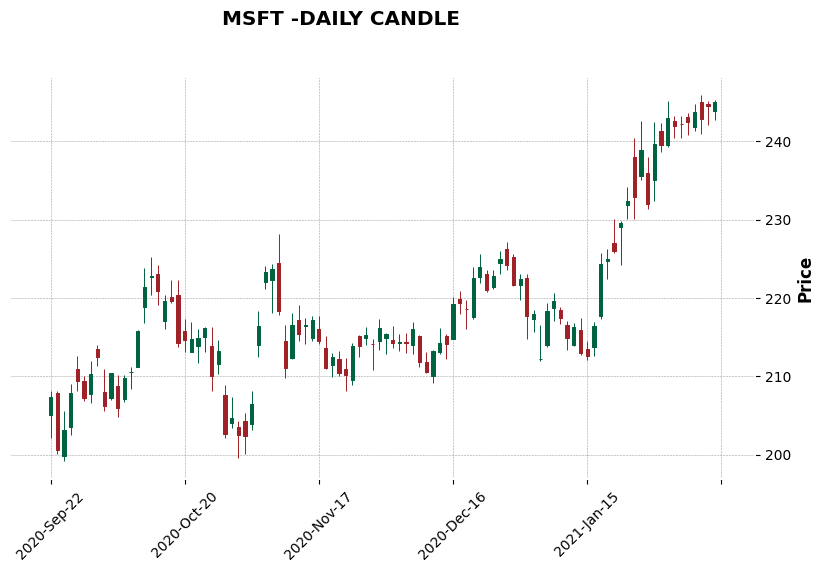

<IPython.core.display.Javascript object>

In [62]:
mpl.plot(
    av_ticker_df[-100:],
    type="candle",
    style="charles",
    figratio=(18, 10),
    title=f"{symbol} -DAILY CANDLE",
)

In [83]:
# Bottom up approach - Lets us evaluate how profitable 20-10 SMA cross-over strategy for IBM is.
# It is same simple as pasisng the correct dataframe and defining the slower moving average time period
# and faster moving time period.
# SO lets get to it.

# Ensure that slow_ma is greater than fast_ma. It makes logical sense.
# If slow_ma < fast_ma, there will be an AssertionError
ma_strategy_df = MAStrategy.evaluate_ma_crossover(
    ticker_df=av_ticker_df,
    slow_ma=20,
    fast_ma=10,
    capture_trend=Trend.BULLISH,
    ma_model=MAModels.EWMA,
)
display(ma_strategy_df.tail())

,,percent_returns,session_details
ma_session_20_10,label_20_10,,
101,bullish,0.956304,2020-10-09 00:00:00-2020-10-27 00:00:00
103,bullish,-4.332553,2020-11-05 00:00:00-2020-11-19 00:00:00
105,bullish,-1.419595,2020-11-27 00:00:00-2020-12-09 00:00:00
107,bullish,1.275902,2020-12-16 00:00:00-2021-01-11 00:00:00
109,bullish,9.029818,2021-01-21 00:00:00-2021-02-12 00:00:00


<IPython.core.display.Javascript object>

Text(0, 0.5, 'Frequency')

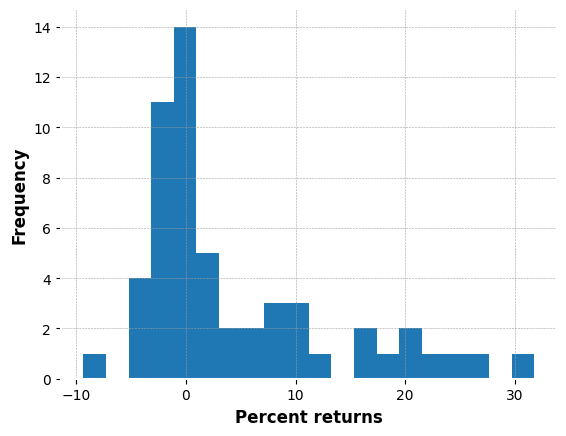

<IPython.core.display.Javascript object>

In [81]:
ax = ma_strategy_df.percent_returns.hist(bins=20)

ax.set_xlabel("Percent returns")
ax.set_ylabel("Frequency")


In [82]:
expected_returns = ma_strategy_df.percent_returns.mean()
print(f"Estimated Expected returns (%) - {expected_returns} %")

Estimated Expected returns (%) - 4.394559449090707 %


<IPython.core.display.Javascript object>

### Top-to-Bottom approach 


* The current implementation of Toucan also allows us to perform the analysis with more granular control. 
* In this section, we shall evaluate the Moving Average strategy using Simple Moving Averages.

In [19]:
# define slow and fast moving average look back periods
# Again, ensure that slow_ma > fast_ma
slow_ma = 20
fast_ma = 10

# create an instance of SMAStrategy
ma_strategy_obj = MAStrategy(ticker_df=av_ticker_df, slow_ma=20, fast_ma=10)


# compute simple moving averages
ma_df = ma_strategy_obj.compute_sma(look_back_periods=[10, 20])
print_heading("Moving Averages")
display(ma_df.head(10))


# we can club the computation of SMA and annotattion using the sma_sessions method as well
ma_sessions_annotated_df = ma_strategy_obj.ma_sessions()

print_heading("Moving Average Cross Over Strategy Annotated Sessions")
display(ma_sessions_annotated_df.head())

# use annotated sessions data to compute percentage returns
column_suffix = f"{slow_ma}_{fast_ma}"
summary_df = ma_sessions_annotated_df.groupby(
    [f"ma_session_{column_suffix}", f"label_{column_suffix}"], as_index=True
).apply(MAStrategy.compute_returns, slow_ma=slow_ma, fast_ma=fast_ma)

print_heading("Returns Summary")
display(summary_df.head())

###############################

Moving Averages

###############################


,ma_10,ma_20
2011-02-28,26.5800,26.5800
2011-03-01,26.1600,26.1600
2011-03-02,26.0775,26.0775
2011-03-03,26.2000,26.2000
2011-03-04,25.9525,25.9525
2011-03-07,25.7200,25.7200
2011-03-08,25.9100,25.9100
2011-03-09,25.8900,25.8900
2011-03-10,25.4100,25.4100
2011-03-11,25.9580,25.6800


###############################

Moving Average Cross Over Strategy Annotated Sessions

###############################


,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,ma_20,ma_10,ma_signal_20_10,ma_session_20_10,label_20_10
2011-02-28,26.6900,26.86,26.51,26.5800,21.258217,51379900.0,0.0,1.0,26.5800,26.5800,False,0,bearish
2011-03-01,26.6000,26.78,26.15,26.1600,20.922309,60055000.0,0.0,1.0,26.1600,26.1600,False,0,bearish
2011-03-02,26.1100,26.37,26.04,26.0775,20.856327,48658200.0,0.0,1.0,26.0775,26.0775,False,0,bearish
2011-03-03,26.2600,26.40,26.18,26.2000,20.954300,68271500.0,0.0,1.0,26.2000,26.2000,False,0,bearish
2011-03-04,26.2200,26.24,25.80,25.9525,20.756354,70437200.0,0.0,1.0,25.9525,25.9525,False,0,bearish
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,243.1500,243.68,240.81,242.4700,242.470000,22211929.0,0.0,1.0,229.0310,238.4960,True,125,bullish
2021-02-09,241.8700,244.76,241.38,243.7700,243.770000,23471475.0,0.0,1.0,230.3450,239.6400,True,125,bullish
2021-02-10,245.0000,245.92,240.89,242.8200,242.820000,22117240.0,0.0,1.0,231.7395,240.6320,True,125,bullish
2021-02-11,244.7800,245.15,242.15,244.4900,244.490000,15751059.0,0.0,1.0,233.1470,241.1880,True,125,bullish


###############################

Returns Summary

###############################


,,percent_returns,session_details
ma_session_20_10,label_20_10,,
0,bearish,3.747073,2011-02-28 00:00:00-2011-03-10 00:00:00
1,bullish,-0.452578,2011-03-11 00:00:00-2011-03-22 00:00:00
2,bearish,-0.234375,2011-03-23 00:00:00-2011-03-31 00:00:00
3,bullish,0.900901,2011-04-01 00:00:00-2011-04-20 00:00:00
4,bearish,-3.879473,2011-04-21 00:00:00-2011-04-29 00:00:00
...,...,...,...
121,bullish,-1.537682,2020-11-12 00:00:00-2020-11-25 00:00:00
122,bearish,0.401176,2020-11-27 00:00:00-2020-12-07 00:00:00
123,bullish,1.645090,2020-12-08 00:00:00-2021-01-11 00:00:00


<IPython.core.display.Javascript object>

Estimated Expected returns (%) - 4.394559449090707 %


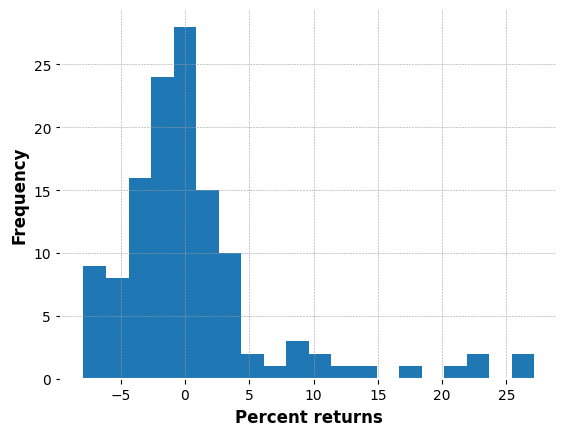

<IPython.core.display.Javascript object>

In [89]:
ax = summary_df.percent_returns.hist(bins=20)

ax.set_xlabel("Percent returns")
ax.set_ylabel("Frequency")

In [90]:
expected_returns = ma_strategy_df.percent_returns.mean()
print(f"Estimated Expected returns (%) - {expected_returns} %")

Estimated Expected returns (%) - 4.394559449090707 %


<IPython.core.display.Javascript object>